In [1]:
!unzip -q '/content/FER-2013.zip'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set random seed for reproducibility
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
train_dir = '/content/train'
test_dir = '/content/test'
classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

In [5]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        # Split data into training and validation sets
        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1  # Normalize image to [-1, 1]
        return img, label

In [7]:
batch_size = 256
train_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageDataset(train_dir, norm=True, label2idx=label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = ImageDataset(test_dir, norm=True, label2idx=label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

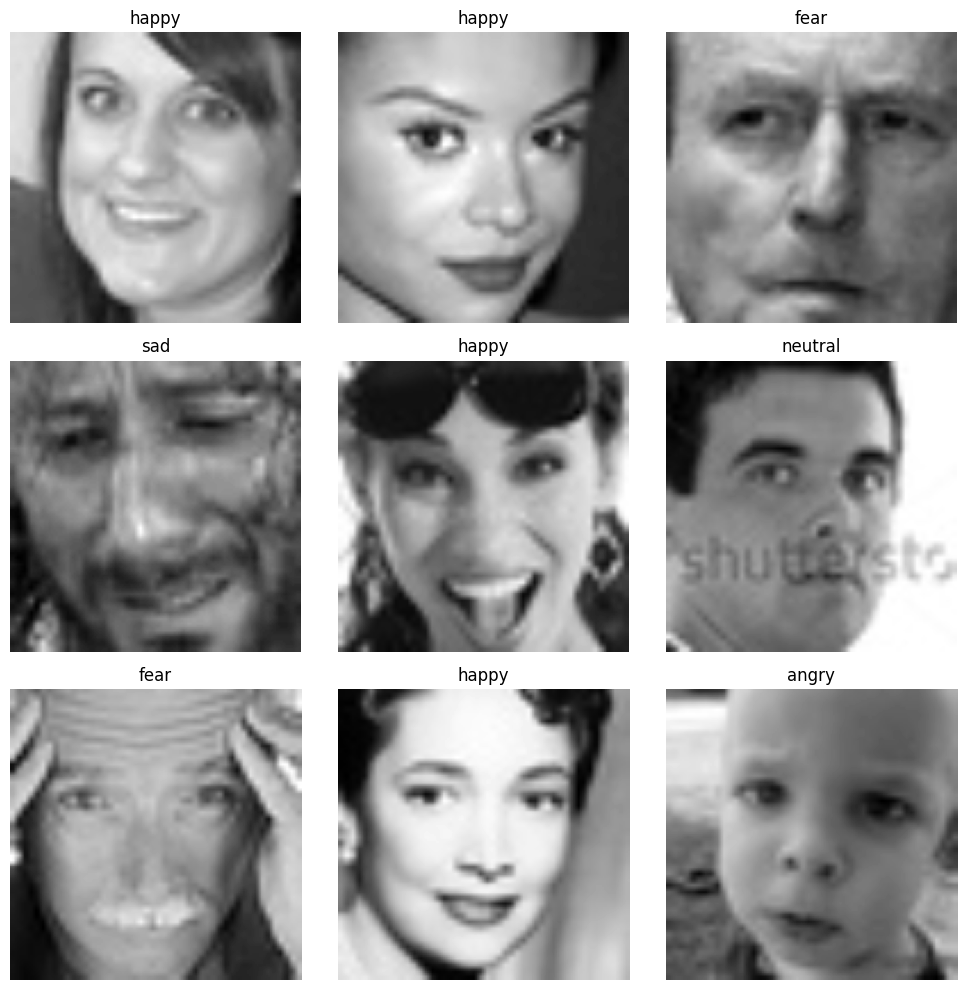

In [8]:
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = image_batch[i].numpy()
    min_val = img.min()
    max_val = img.max()
    plt.imshow(np.squeeze(img), vmin=min_val, vmax=max_val, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
#         self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
#         self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
#         self.output = nn.Linear(hidden_dims, output_dims)

#     def forward(self, x):
#         x = nn.Flatten()(x)  # Flatten the input tensor
#         x = self.linear1(x)
#         x = F.relu(x)  # Apply ReLU activation
#         x = self.linear2(x)
#         x = F.relu(x)
#         x = self.linear3(x)
#         x = F.relu(x)
#         out = self.output(x)
#         return out.squeeze(1)  # Remove single-dimensional entries from the shape

# class MLP(nn.Module):
#     def __init__(self, input_dims, hidden_dims, output_dims):
#         super(MLP, self).__init__()
#         self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
#         self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
#         self.output = nn.Linear(hidden_dims * 2, output_dims)

#     def forward(self, x):
#         x = nn.Flatten()(x)
#         x = self.linear1(x)
#         x = F.relu(x)
#         x = self.linear2(x)
#         x = F.relu(x)
#         out = self.output(x)
#         return out.squeeze(1)

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_width
output_dims = len(classes)           # Number of classes
hidden_dims = 64                     # Hidden layer size
lr = 1e-2                            # Learning rate

# Instantiate the model and move it to the appropriate device
model = MLP(
    input_dims=input_dims,
    hidden_dims=hidden_dims,
    output_dims=output_dims
).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)  # Get predicted class indices
    correct = (y_hat == y_true).sum().item()  # Count correct predictions
    accuracy = correct / len(y_true)  # Compute accuracy
    return accuracy

In [12]:
epochs = 40

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Training and validation loop
for epoch in range(epochs):
    # Training phase
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_samples)  # Forward pass
        loss = criterion(outputs, y_samples)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate training loss
        train_predict.append(outputs.detach().cpu())  # Store predictions
        train_target.append(y_samples.cpu())  # Store targets

    # Compute average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Concatenate predictions and targets for accuracy calculation
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation phase
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()

    with torch.no_grad():  # Disable gradient computation for validation
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)

            outputs = model(X_samples)  # Forward pass
            val_loss += criterion(outputs, y_samples).item()  # Compute loss

            val_predict.append(outputs.cpu())  # Store predictions
            val_target.append(y_samples.cpu())  # Store targets

    # Compute average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Concatenate predictions and targets for accuracy calculation
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Print epoch summary
    print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}\t"
          f"Training accuracy: {train_acc:.3f}\tValidation accuracy: {val_acc:.3f}")


EPOCH 1:	Training loss: 1.911	Validation loss: 1.877	Training accuracy: 0.214	Validation accuracy: 0.250

EPOCH 2:	Training loss: 1.843	Validation loss: 1.817	Training accuracy: 0.251	Validation accuracy: 0.252

EPOCH 3:	Training loss: 1.800	Validation loss: 1.789	Training accuracy: 0.258	Validation accuracy: 0.266

EPOCH 4:	Training loss: 1.778	Validation loss: 1.773	Training accuracy: 0.272	Validation accuracy: 0.282

EPOCH 5:	Training loss: 1.762	Validation loss: 1.757	Training accuracy: 0.291	Validation accuracy: 0.296

EPOCH 6:	Training loss: 1.745	Validation loss: 1.739	Training accuracy: 0.306	Validation accuracy: 0.316

EPOCH 7:	Training loss: 1.725	Validation loss: 1.718	Training accuracy: 0.321	Validation accuracy: 0.326

EPOCH 8:	Training loss: 1.703	Validation loss: 1.698	Training accuracy: 0.333	Validation accuracy: 0.334

EPOCH 9:	Training loss: 1.683	Validation loss: 1.678	Training accuracy: 0.344	Validation accuracy: 0.343

EPOCH 10:	Training loss: 1.665	Validation los

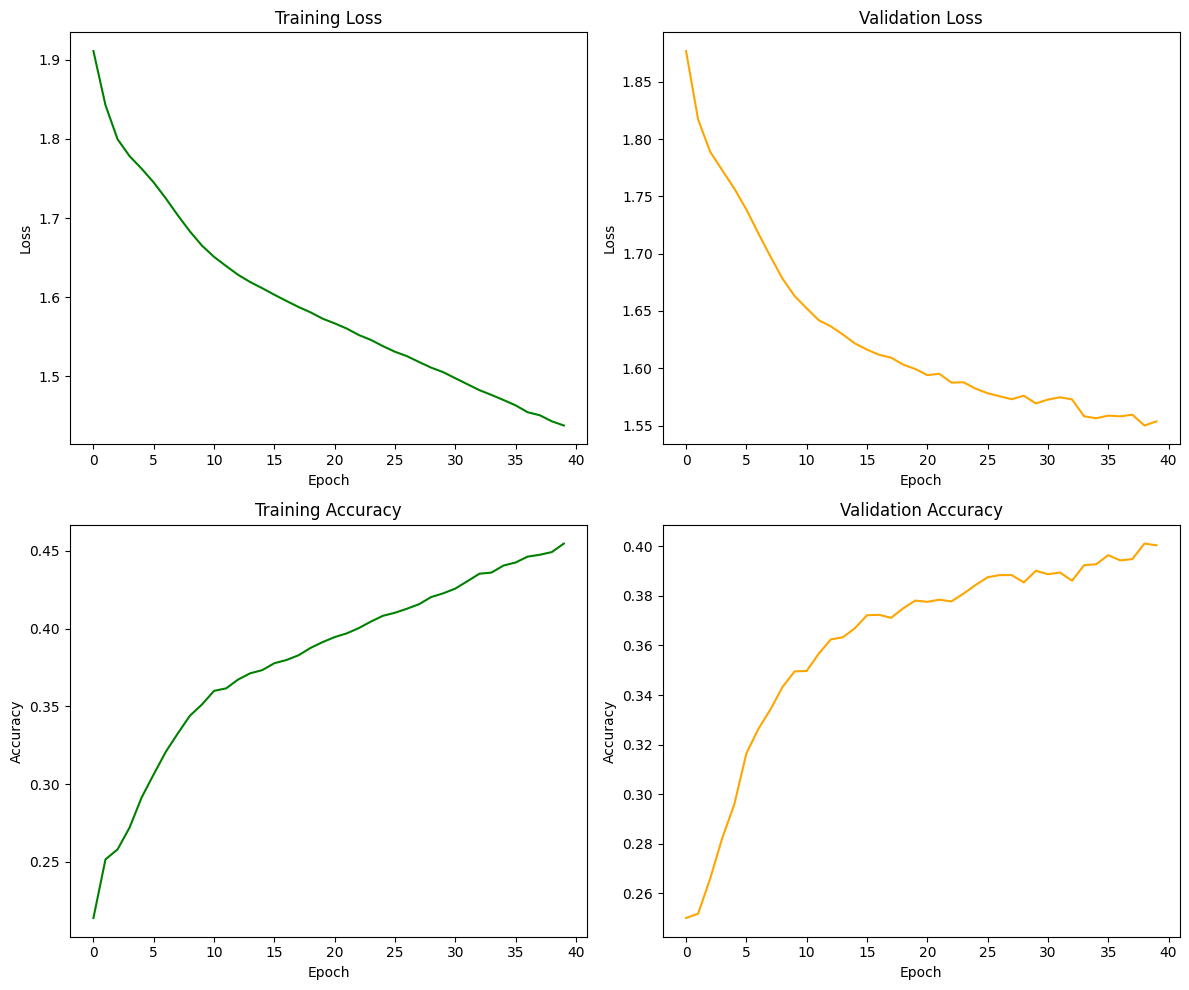

In [13]:
import matplotlib.pyplot as plt

# Create subplots for training and validation metrics
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot training loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Plot validation loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Plot training accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Plot validation accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [14]:
# Initialize lists to store predictions and targets
test_target = []
test_predict = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        # Move data to the appropriate device
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)

        # Perform forward pass
        outputs = model(X_samples)

        # Append predictions and targets
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

# Concatenate all predictions and targets
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Compute accuracy on the test set
test_acc = compute_accuracy(test_predict, test_target)

# Print test evaluation results
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.3f}')

Evaluation on test set:
Accuracy: 0.410
